### Naive bayes classifier

In [2]:
import pathlib 

import numpy as np
import pandas as pd
from sklearn.metrics import f1_score
from ipywidgets import interact_manual
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

In [3]:
df = pd.DataFrame(columns=["state", "gender", "year", "name", "number"])
for path in pathlib.Path('/data').glob('*.TXT'):
    state = pd.read_csv(path, names=["state", "gender", "year", "name", "number"], header=None)
    df = df.append(state)
df = df.astype({'number':'int64'})
df.head()

,state,gender,year,name,number
0,IN,F,1910,Mary,619
1,IN,F,1910,Helen,324
2,IN,F,1910,Ruth,238
3,IN,F,1910,Dorothy,215
4,IN,F,1910,Mildred,200


In [4]:
#https://www.kaggle.com/springboardroger/naive-bayes-name-gender-classifier
names_by_gender = df.groupby(['name', 'gender'], as_index=False).agg({'number':sum})
names_by_gender.head(5)

,name,gender,number
0,Aaban,M,12
1,Aadan,M,23
2,Aadarsh,M,5
3,Aaden,M,4114
4,Aadhav,M,37


In [5]:
names_by_gender = names_by_gender.pivot('name', 'gender', 'number')
names_by_gender = names_by_gender.reset_index().fillna(0)
names_by_gender.head()

gender,name,F,M
0,Aaban,0.0,12.0
1,Aadan,0.0,23.0
2,Aadarsh,0.0,5.0
3,Aaden,0.0,4114.0
4,Aadhav,0.0,37.0


In [6]:
#Data cleaning
names_by_gender["Mpercent"] = ((names_by_gender["M"] - names_by_gender["F"])/(names_by_gender["M"] + names_by_gender["F"]))
names_by_gender['gender'] = np.where(names_by_gender['Mpercent'] > 0.001, 'male', 'female')
names_by_gender.set_index("name", inplace=True)
names_by_gender.head()

gender,F,M,Mpercent,gender
name,,,,
Aaban,0.0,12.0,1.0,male
Aadan,0.0,23.0,1.0,male
Aadarsh,0.0,5.0,1.0,male
Aaden,0.0,4114.0,1.0,male
Aadhav,0.0,37.0,1.0,male


In [7]:
char_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))
X = char_vectorizer.fit_transform(names_by_gender.index)

#Convert this matrix to Compressed Sparse Column format
X = X.tocsc()
Y = (names_by_gender.gender == 'male').values.astype(np.int)

In [8]:
char_vectorizer.inverse_transform(X[0])

[array(['aa', 'ab', 'an', 'ba'], dtype='<U2')]

In [9]:
#Use k-fold cross validation instead
#https://stackoverflow.com/questions/16123572/k-fold-cross-validation-for-naive-bayes-classifier
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.7)

In [10]:
clf = MultinomialNB(alpha = 1)
clf.fit(X_train, Y_train)
training_accuracy = clf.score(X_train,Y_train)
test_accuracy = clf.score(X_test,Y_test)
        
print(training_accuracy)
print(test_accuracy)

0.7368421052631579
0.7258149593839013


In [11]:
Y_pred = clf.predict(X_test)

[[4793 1020]
 [1579 2087]]


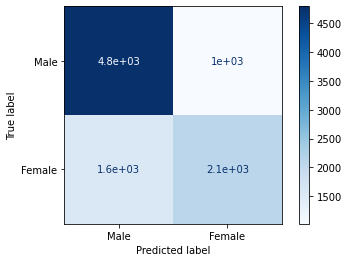

In [12]:
# confusion_matrix(Y_test, Y_pred)
import matplotlib.pyplot as plt
disp = plot_confusion_matrix(clf, X_test, Y_test,
                                 display_labels=["Male", "Female"],
                                 cmap=plt.cm.Blues)
# disp.ax_.set_title(title)

# print(title)
print(disp.confusion_matrix)

In [13]:
@interact_manual
def predict(x="Roger"):
    new = char_vectorizer.transform([x])
    y_pred = clf.predict(new)
    if (y_pred == 1):
        print("Male!")
    else:
        print("Female!")

interactive(children=(Text(value='Roger', description='x'), Button(description='Run Interact', style=ButtonSty…